# Inspired from work by Jencka and Adams

In [307]:
import pandas as pd
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

In [308]:
header = ("X", "Y", "Z", "TIME", "SLURM_NNODES", "SLURM_NTASKS_PER_NODE", "OMP_NUM_THREADS", "SLURM_GPUS_PER_NODE", "GFLOPS")

In [309]:
dat_hopper = pd.read_csv('global_results.csv', names=header)
dat_hopper['Cluster'] = 'Hopper'
dat_hopper.loc[dat_hopper['SLURM_GPUS_PER_NODE'] > 0, 'Cluster'] = "Hopper (GPU)"

In [310]:
# Trim initial malformed results
dat_hopper = dat_hopper.iloc[1185:]

In [311]:
data = pd.concat((dat_hopper,))
data

,X,Y,Z,TIME,SLURM_NNODES,SLURM_NTASKS_PER_NODE,OMP_NUM_THREADS,SLURM_GPUS_PER_NODE,GFLOPS,Cluster
1185,8,8.0,8.0,90.0,1.0,2.0,1.0,2.0,0.014596,Hopper (GPU)
1186,8,8.0,32.0,90.0,1.0,2.0,1.0,2.0,0.028943,Hopper (GPU)
1187,8,8.0,56.0,90.0,1.0,2.0,1.0,2.0,0.050927,Hopper (GPU)
1188,8,8.0,8.0,90.0,4.0,1.0,1.0,1.0,5.508880,Hopper (GPU)
1189,8,8.0,32.0,90.0,4.0,1.0,1.0,1.0,10.878000,Hopper (GPU)
...,...,...,...,...,...,...,...,...,...,...
5227,32,40.0,72.0,90.0,1.0,32.0,1.0,0.0,0.425300,Hopper
5228,32,40.0,80.0,90.0,1.0,32.0,1.0,0.0,0.482069,Hopper
5229,24,64.0,24.0,90.0,2.0,32.0,1.0,0.0,0.290212,Hopper
5230,56,24.0,16.0,90.0,4.0,1.0,1.0,0.0,9.493280,Hopper


In [312]:
data['Process Count'] = data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'] * data['OMP_NUM_THREADS']
set(data['Process Count'])

{1.0, 2.0, 4.0, 16.0, 32.0, 64.0, nan, 128.0}

In [313]:
data['Problem Size'] = data['X'] * data['Y'] * data['Z']
print(data['Problem Size'].max() ** (1.0 / 3.0))

data['Global Problem Size'] = data['Problem Size'] * ((data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE']) ** 3.0)
print(data['Global Problem Size'].max() ** (1.0 / 3.0))

82.30621182481418
2994.1941639299735


In [314]:
data['SLURM_GPUS_PER_NODE'].max()

2.0

In [315]:
data['OMP_NUM_THREADS'].max()

4.0

# Plots

In [316]:
def label_peaks(df, groupby, value, troughs=False):
    mean = df.groupby(groupby).mean(numeric_only=True)[value]
    idx, _ = signal.find_peaks(mean)
    peaks = mean.iloc[idx]

    if troughs:
        idx, _ = signal.find_peaks(-mean)
        peaks = pd.concat((peaks, mean.iloc[idx]))

    for (x, y) in peaks.items():
        plt.text(x, y, str(x), path_effects=[pe.withStroke(linewidth=4, foreground="white")])

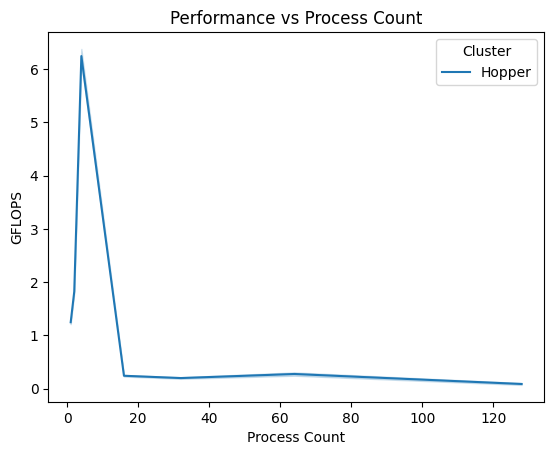

In [317]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count.svg')

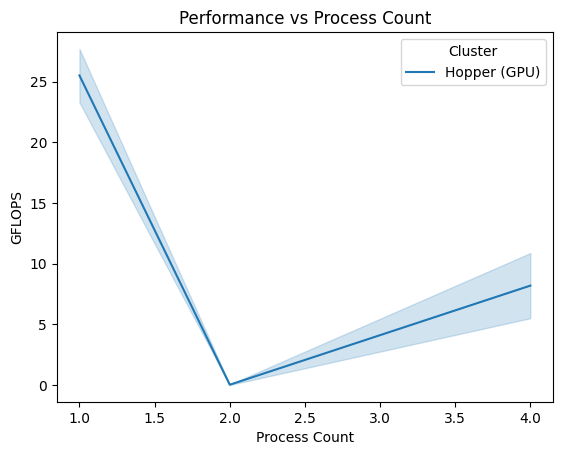

In [318]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count_gpu.svg')

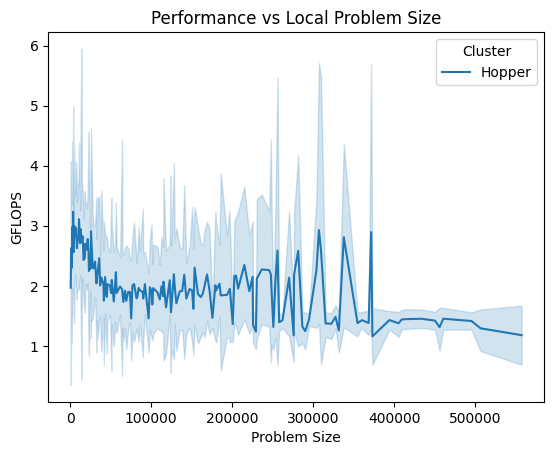

In [319]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Local Problem Size')
plt.savefig('figures/flops_local_problem_size.svg')

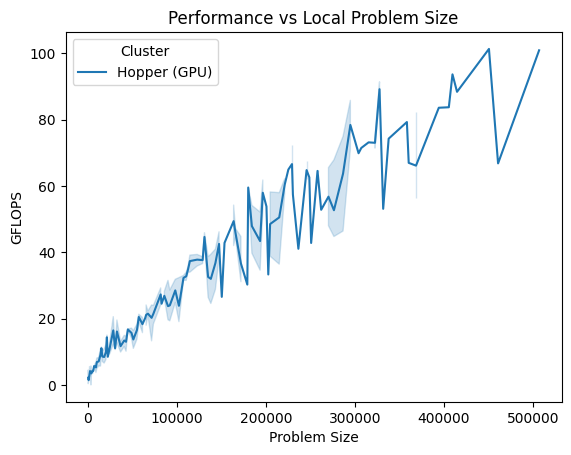

In [320]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Local Problem Size')
plt.savefig('figures/flops_local_problem_size_gpu.svg')

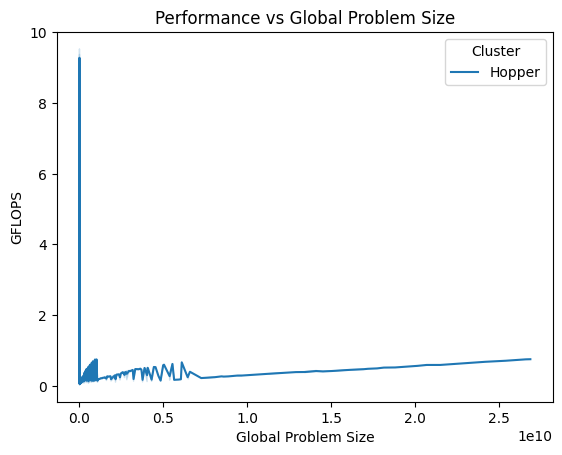

In [321]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Global Problem Size')
plt.savefig('figures/flops_global_problem_size.svg')

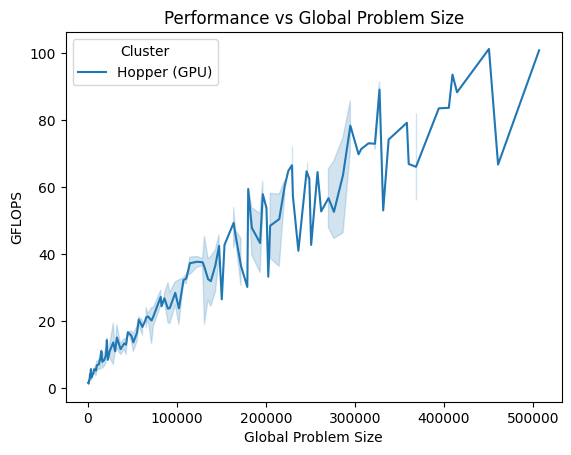

In [322]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Global Problem Size')
plt.savefig('figures/flops_global_problem_size_gpu.svg')

# Statistics

In [323]:
# Summary Stats for performance of ALL runs
stats_all_runs = data["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_all_runs

count    4046.000000
mean        4.384691
std         9.795947
min         0.014596
25%         0.691012
50%         1.619635
75%         3.187035
90%         8.731230
95%        16.369400
99%        59.170040
max       101.310000
Name: GFLOPS, dtype: float64

In [324]:
# Summary stats for Hopper
stats_hopper = data[data['Cluster'] == 'Hopper']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper

count    3663.000000
mean        2.206889
std         2.406260
min         0.019409
25%         0.597942
50%         1.546410
75%         2.584020
90%         6.055328
95%         8.200059
99%         9.122379
max         9.593380
Name: GFLOPS, dtype: float64

In [325]:
# Summary stats for Hopper (GPU)
stats_hopper_gpu = data[data['Cluster'] == 'Hopper (GPU)']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper_gpu

count    383.000000
mean      25.213124
std       21.913076
min        0.014596
25%        8.216705
50%       17.441700
75%       35.368650
90%       59.881040
95%       69.862730
99%       88.925212
max      101.310000
Name: GFLOPS, dtype: float64

In [326]:
# latex
print(pd.concat([stats_all_runs, stats_hopper, stats_hopper_gpu], axis=1).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &       GFLOPS &       GFLOPS &      GFLOPS \\
\midrule
count &  4046.000000 &  3663.000000 &  383.000000 \\
mean  &     4.384691 &     2.206889 &   25.213124 \\
std   &     9.795947 &     2.406260 &   21.913076 \\
min   &     0.014596 &     0.019409 &    0.014596 \\
25\%   &     0.691012 &     0.597942 &    8.216705 \\
50\%   &     1.619635 &     1.546410 &   17.441700 \\
75\%   &     3.187035 &     2.584020 &   35.368650 \\
90\%   &     8.731230 &     6.055328 &   59.881040 \\
95\%   &    16.369400 &     8.200059 &   69.862730 \\
99\%   &    59.170040 &     9.122379 &   88.925212 \\
max   &   101.310000 &     9.593380 &  101.310000 \\
\bottomrule
\end{tabular}



# Gustafson's like

In [327]:
one_thread = data[data['OMP_NUM_THREADS'] == 1]

In [328]:
past_3e6 = one_thread[one_thread['Global Problem Size'] > .25e10]

In [329]:
pre_3e6 = one_thread[one_thread['Global Problem Size'] < 1e9]

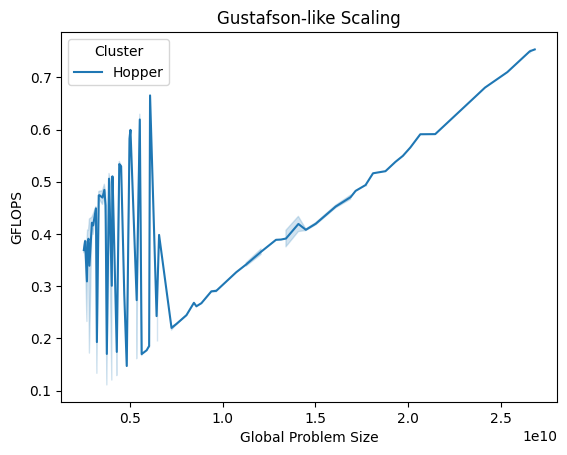

In [330]:
sns.lineplot(past_3e6[past_3e6['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_big.svg')

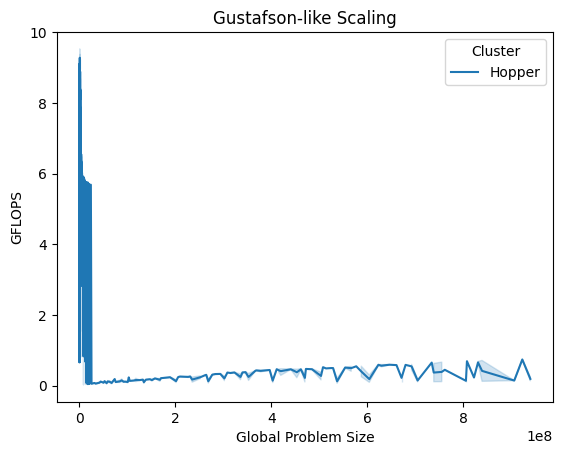

In [331]:
sns.lineplot(pre_3e6[pre_3e6['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_small.svg')

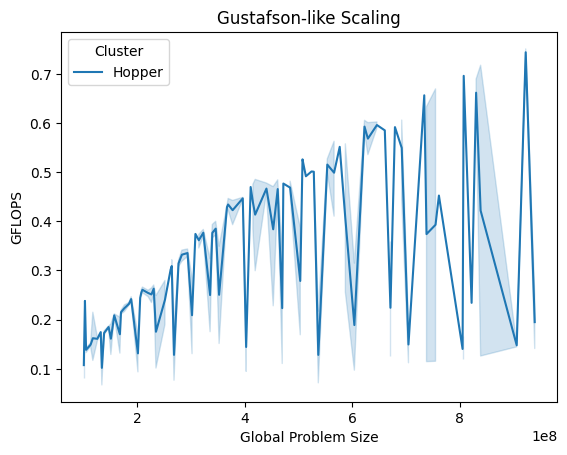

In [332]:
cutlow = pre_3e6[pre_3e6['Global Problem Size'] > 1e8]
sns.lineplot(cutlow[cutlow['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_small_cutlow.svg')

# Cubic

In [333]:
local_cube_root = data['Problem Size'].pow(1.0 / 3.0)
global_cube_root = data['Global Problem Size'].pow(1.0 / 3.0)
data["Local close to cube"] = np.sqrt(((local_cube_root - data['X']) ** 2.0) + ((local_cube_root - data['Y']) ** 2.0) + ((local_cube_root - data['Z']) ** 2.0))
data["Global close to cube"] = np.sqrt(((global_cube_root - (data['X'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0) + \
                                        ((global_cube_root - (data['Y'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0) + \
                                        ((global_cube_root - (data['Z'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0))

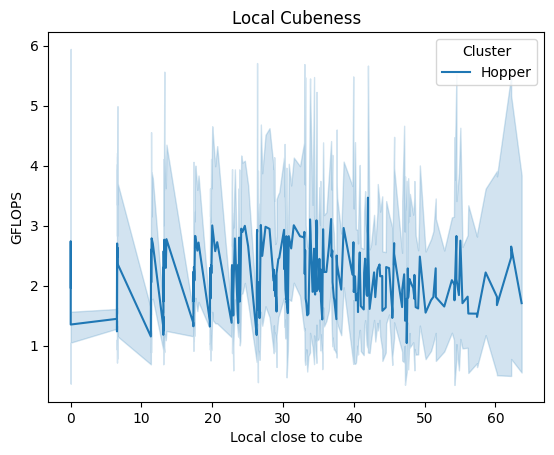

In [334]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Local close to cube", y="GFLOPS", hue='Cluster')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Local Cubeness')
plt.savefig('figures/flops_cubeness_local.svg')

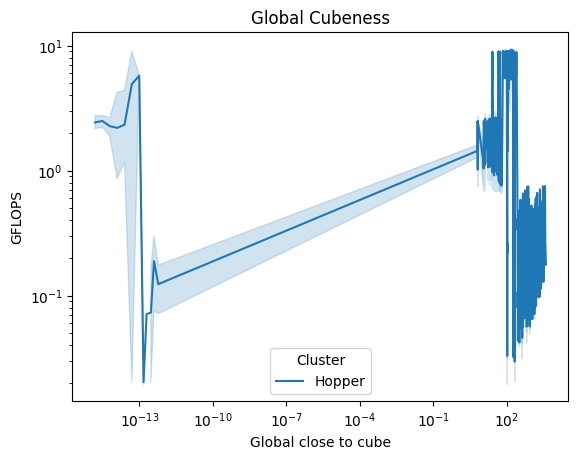

In [335]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global.svg')

In [336]:
past_500 = data[data['Global close to cube'] > 500]
pre_300 = data[data['Global close to cube'] < 300]

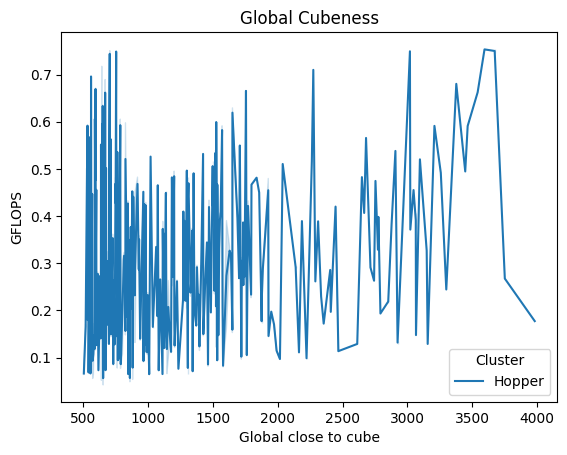

In [337]:
sns.lineplot(past_500[past_500['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global_large.svg')

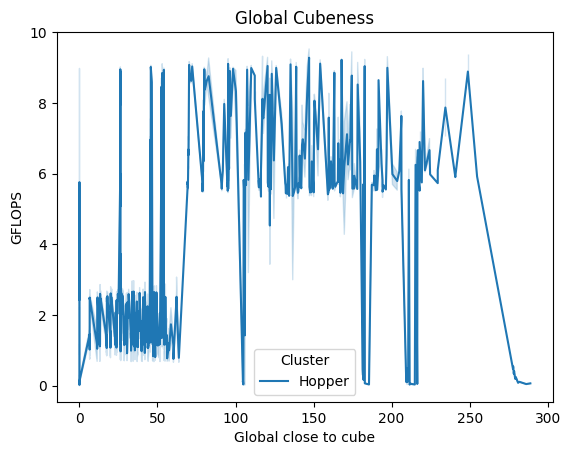

In [338]:
sns.lineplot(pre_300[pre_300['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global_small.svg')

# CPU vs GPU

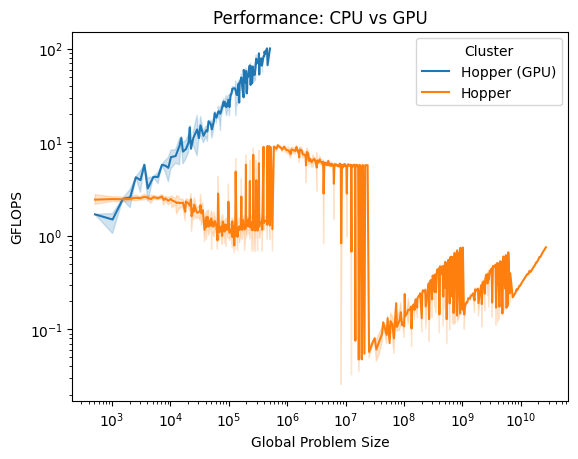

In [339]:
sns.lineplot(data, x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance: CPU vs GPU')
plt.savefig('figures/flops_global_problem_size_cpu_vs_gpu.svg')

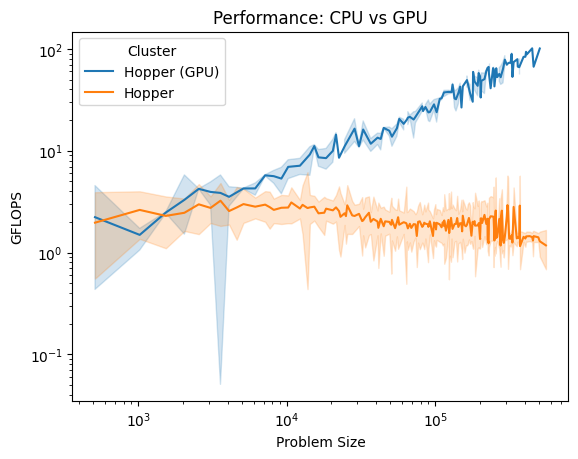

In [340]:
sns.lineplot(data, x="Problem Size", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance: CPU vs GPU')
plt.savefig('figures/flops_local_problem_size_cpu_vs_gpu.svg')